In [1]:
string_colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'black',
    'white',
    'purple'
]

from comparison.heuristic import solve_heuristic
from comparison.sat import solve_sat
import torch
from torch import nn
from torch.nn import LSTM
from torch.autograd import Variable
from gen_data.data_generation import graph_to_compressed, compressed_to_adj
from itertools import chain

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        sample = torch.tensor(sample, dtype=torch.float32)

        if self.transform:
            sample = self.transform(sample)

        return sample

from typing import List

def color_correction_procedure(adj : List[List[int]], colors : List[int]):
    old_colors = len(set(colors))

    colors_index = dict()

    for index, color in enumerate(colors):
        if color not in colors_index:
            n = len(colors_index)
            colors_index[color] = n
            colors[index] = n
        else:
            colors[index] = colors_index[color]
    
    n = len(adj)
    colors_count = len(set(colors))

    for i in range(n):
        for j in range(i + 1, n):
            if adj[i][j] == 0:
                continue
        
            if colors[i] != colors[j]:
                continue

            neighbours = [index for index, elem in enumerate(adj[i]) if elem == 1]

            nei_colors = set(map(lambda nei : colors[nei], neighbours))
            
            available = set(colors).difference(nei_colors)

            if len(available) > 0:
                new_color = list(available)[0]

                colors[i] = new_color
                continue

            neighbours = [index for index, elem in enumerate(adj[j]) if elem == 1]
            nei_colors = set(map(lambda nei : colors[nei], neighbours))
            
            available = set(colors).difference(nei_colors)

            if len(available) > 0:
                new_color = list(available)[0]

                colors[j] = new_color
                continue
                
            # none of the above, we need to create a new color

            new_color = colors_count
            colors_count += 1

            colors[i] = new_color

    return old_colors, len(set(colors)), colors

def get_coloring(model, graph, linearized = False):
    adj = compressed_to_adj(graph_to_compressed(graph))

    original_adj = adj

    if linearized:
        adj = list(chain(adj))

    dataloader = torch.utils.data.DataLoader(dataset=CustomDataset(data=[adj]), batch_size=1, shuffle=False)

    res = []

    model.eval()

    for _, inputs in enumerate(dataloader):
        inputs = Variable(inputs)

        with torch.no_grad():
            res.append(model(inputs))
    
    res = list(map(lambda t: torch.flatten(t, start_dim=0), res))
    res = list(map(lambda t: list(t.detach().numpy()), res))

    res = list(map(lambda cols: list(map(lambda col: int(round(col)), cols)), res))

    res = res[0]

    if linearized:
        res[1] = res[0] + 1
        res[int(graph.vcount() / 2)] = res[0] + 1
        res[int(graph.vcount() / 6)] = res[0] + 1
        res[int(graph.vcount() / 1.5)] = res[0] + 1

    old_colors = list(map(lambda x: int(round(x)), res))

    _, _, colors = color_correction_procedure(original_adj, res)

    return old_colors, colors

GRAF ORIGINAL


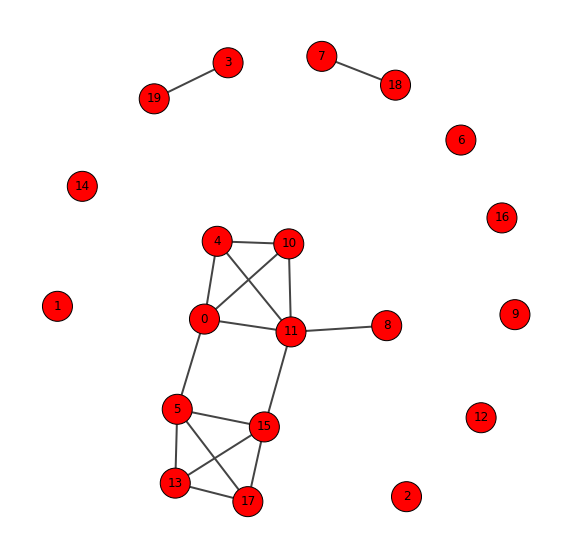

In [2]:
import igraph as ig
from igraph import Graph
import matplotlib.pyplot as plt
from gen_data.data_generation import generate_clique_graph

n = 20
sparsity = 0.15
g = generate_clique_graph(n, sparsity=0.1)
# g = Graph.Erdos_Renyi(n=n, p=sparsity)

g.vs["label"] = list(range(n))

# Plot the graph
layout = g.layout("kk")
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(g, layout=layout, target=ax)

print('GRAF ORIGINAL')
plt.show()

In [3]:
class ColoringNN(nn.LSTM):
    def __init__(self, in_size : int, out_size : int,
                  hidden_size : int, num_layers : int, num_nodes : int):
        super(ColoringNN, self).__init__(input_size=in_size, hidden_size=hidden_size)

        self.in_size = in_size
        self.out_size = out_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_nodes = num_nodes

        self.cells = nn.ModuleList([
            LSTM(
                input_size = in_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
            )
            for _ in range(num_nodes)
        ])

        self.linear = nn.Linear(in_features=hidden_size, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        outputs = []

        for i, lstm in enumerate(self.cells):
            out, _ = lstm(inputs[:, [i], :])

            out = self.linear(out)
            out = torch.flatten(input=out, start_dim=0)
            out = self.relu(out)

            outputs.append(out.unsqueeze(-1))

        res = torch.cat(outputs, dim=1)
        return res


COLORARE EURISTICA


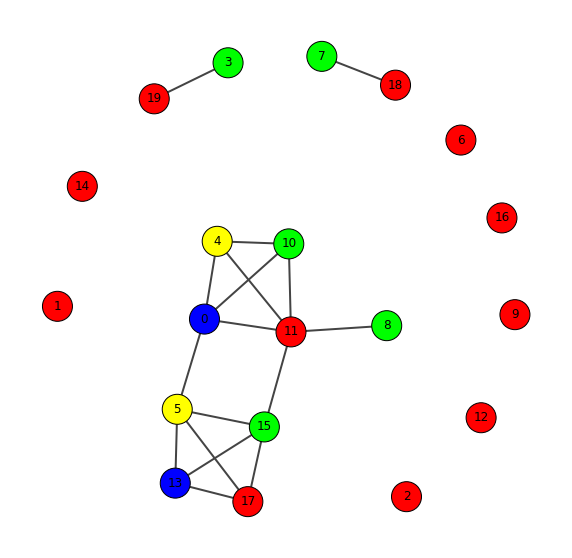

In [4]:
_, colors = solve_heuristic(g)
colors = [string_colors[colors[index]] for index in range(g.vcount())]

g.vs['color'] = colors

layout = g.layout("kk")
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(g, layout=layout, target=ax)

print('COLORARE EURISTICA')
plt.show()

COLORARE AGRESIVA - MODEL ORIGINAL


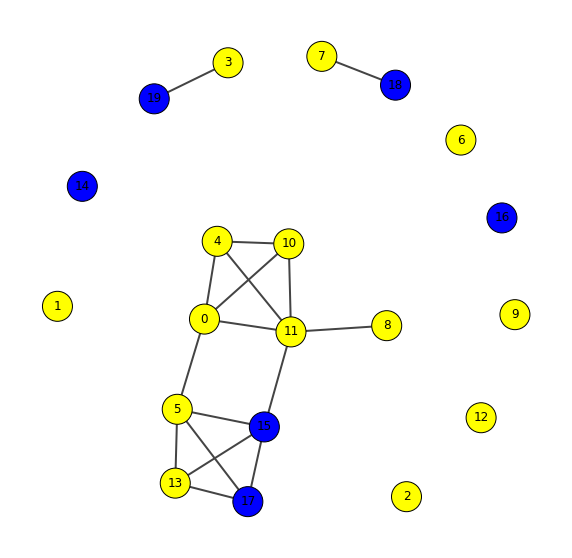

COLORARE CORECTATA - MODEL ORIGINAL


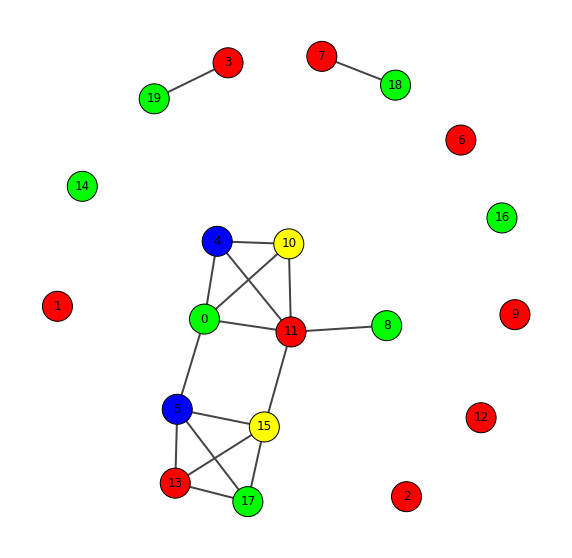

In [5]:
model = torch.load('model_base.pth')
old_colors, colors = get_coloring(model, g, linearized=False)

colors = [string_colors[colors[index]] for index in range(g.vcount())]
old_colors = [string_colors[old_colors[index]] for index in range(g.vcount())]

g.vs['color'] = old_colors

layout = g.layout("kk")
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(g, layout=layout, target=ax)

print('COLORARE AGRESIVA - MODEL ORIGINAL')
plt.show()

g.vs['color'] = colors

layout = g.layout("kk")
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(g, layout=layout, target=ax)

print('COLORARE CORECTATA - MODEL ORIGINAL')
plt.show()

In [6]:
class ColoringNN(nn.LSTM):
    def __init__(self, in_size : int, out_size : int,
                  hidden_size : int, num_layers : int, num_nodes : int):
        super(ColoringNN, self).__init__(input_size=in_size, hidden_size=hidden_size)

        self.in_size = in_size
        self.out_size = out_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_nodes = num_nodes

        self.lstm = LSTM(
                input_size = in_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
            )

        self.linear = nn.Linear(in_features=hidden_size, out_features=OUT_SIZE)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        outputs, _ = self.lstm(inputs)
        outputs = self.linear(outputs)
        outputs = self.relu(outputs)
        return outputs

COLORARE AGRESIVA - MODEL PROPUS


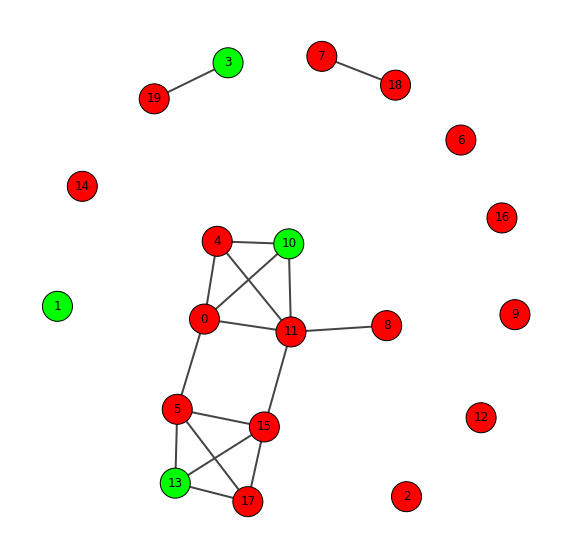

COLORARE CORECTATA - MODEL PROPUS


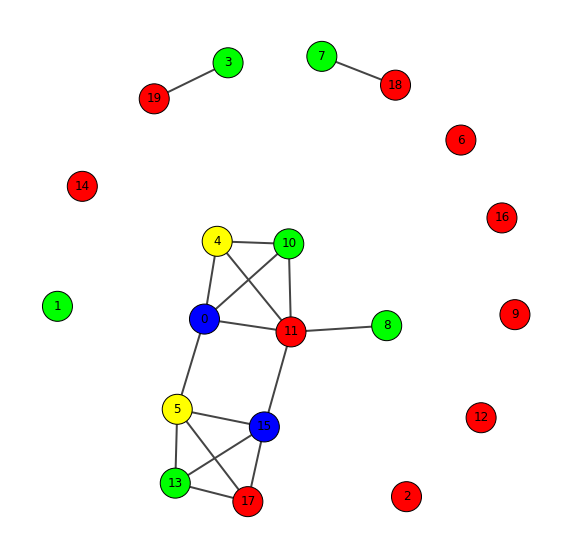

In [7]:
model = torch.load('model_original_clique.pth')
old_colors, colors = get_coloring(model, g, linearized=True)

colors = [string_colors[colors[index]] for index in range(g.vcount())]
old_colors = [string_colors[old_colors[index]] for index in range(g.vcount())]

g.vs['color'] = old_colors

layout = g.layout("kk")
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(g, layout=layout, target=ax)

print('COLORARE AGRESIVA - MODEL PROPUS')
plt.show()

g.vs['color'] = colors

layout = g.layout("kk")
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(g, layout=layout, target=ax)

print('COLORARE CORECTATA - MODEL PROPUS')
plt.show()